# Customer Feed back System
- find sentiment
- dignose it 
- response it 


In [42]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.prompts import PromptTemplate
from dotenv import load_dotenv
load_dotenv()

True

In [43]:
llm=ChatOpenAI(
    model='gpt-4o-mini'
)

In [44]:
# schemas to get structured output
# schema for sentiment
class SentimentSchema(BaseModel):
    sentiment: Literal['positive','negative'] = Field(description="Sentiment of the Review")

# schema for diagnose issue
class DiagnoseSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [45]:
# structured llm
# for sentiment
llm_sentiment=llm.with_structured_output(SentimentSchema)
# for diagnose
llm_diagnose=llm.with_structured_output(DiagnoseSchema)

In [46]:
# first create state
class ReviewState(TypedDict):

    review: str
    sentiment: Literal['positive','negative']
    diagnose:dict
    response:str


In [47]:
# code for get_sentiment
def get_sentiment(state: ReviewState)->ReviewState:
    review=state['review']
    prompt=PromptTemplate.from_template(
        "Classify the following Review as positive or negative \n Review: {review}"
    )
    chain=prompt | llm_sentiment
    sentiment=chain.invoke({'review':review})

    return {'sentiment':sentiment}


In [48]:
# check condition 

def check_condition(state: ReviewState)->Literal['positive_response','diagnose']:
    if state['review']=='positive':
        return 'positive_response'
    else:
        return 'diagnose'

In [49]:
# code for positive_response

def positive_response(state: ReviewState)->ReviewState:
    prompt=PrompTemplate.from_template(
        "Write a positive response to the following positive review form customer say Thank you and ask for good review \n review: {review}"
    )
    chain=prompt | llm
    pos_review=chain.invoke({'review':state['review']})
    return {'response':pos_review}
    

In [50]:
# code for diagnose
def diagnose(state: ReviewState)->ReviewState:
    prompt=PromptTemplate.from_template(
        "Based on the following negative review return issue_type,tonie and urgency \n review: {review}"
    )
    chain=prompt | llm_diagnose
    diagnose=chain.invoke({
        'review':state['review']
    })

    return {'diagnose':diagnose.model_dump()}

In [51]:
# code for negative_response

def negative_response(state: ReviewState)->ReviewState:
    diagnose=state['diagnose']
    prompt=PromptTemplate.from_template(
        "User has negative response with issue type : {issue_type} \n review tone : {tone} \nand urgency : {urgency} based on these write a helpful feedback for the customer"
    )
    chain=prompt | llm
    neg_response=chain.invoke({
        'issue_type':diagnose['issue_type'],
        'tone':diagnose['tone'],
        'urgency':diagnose['urgency']
    })

    return {'response':neg_response}

In [52]:
graph=StateGraph(ReviewState)
graph.add_node('get_sentiment',get_sentiment)
graph.add_node('positive_response',positive_response)
graph.add_node('diagnose',diagnose)
graph.add_node('negative_response',negative_response)

graph.add_edge(START,'get_sentiment')
graph.add_conditional_edges('get_sentiment',check_condition)
graph.add_edge('positive_response',END)
graph.add_edge('diagnose','negative_response')
graph.add_edge('negative_response',END)

workflow=graph.compile()


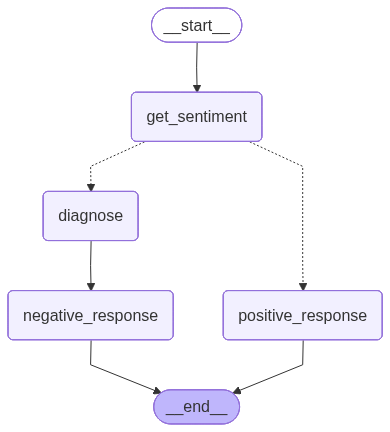

In [53]:
workflow


In [54]:
review='''I had high expectations, but unfortunately this experience was disappointing. The quality fell short in several areas. The explanations were unclear and inconsistent, making it difficult to follow along. On top of that, the results didn’t match what was promised, which left me frustrated. Communication could also have been better — questions often went unanswered or were addressed vaguely. Overall, it felt rushed and not well thought out. I wouldn’t recommend it unless these issues are fixed.'''

In [55]:
result=workflow.invoke({
    'review':review
})

In [57]:
result

{'review': 'I had high expectations, but unfortunately this experience was disappointing. The quality fell short in several areas. The explanations were unclear and inconsistent, making it difficult to follow along. On top of that, the results didn’t match what was promised, which left me frustrated. Communication could also have been better — questions often went unanswered or were addressed vaguely. Overall, it felt rushed and not well thought out. I wouldn’t recommend it unless these issues are fixed.',
 'sentiment': SentimentSchema(sentiment='negative'),
 'diagnose': {'issue_type': 'UX', 'tone': 'frustrated', 'urgency': 'medium'},
 'response': AIMessage(content="Subject: We're Here to Help with Your UX Concerns\n\nDear [Customer's Name],\n\nThank you for reaching out and sharing your feedback regarding your recent experience with our [product/service]. We sincerely apologize for the frustration this has caused you. \n\nUnderstanding your concerns about the user experience is very i

In [60]:
print(result['response'].content)

Subject: We're Here to Help with Your UX Concerns

Dear [Customer's Name],

Thank you for reaching out and sharing your feedback regarding your recent experience with our [product/service]. We sincerely apologize for the frustration this has caused you. 

Understanding your concerns about the user experience is very important to us, and we want to assure you that we take these matters seriously. To help us address your issues effectively, could you please provide more specific details about what you found frustrating? Whether it's navigation challenges, functionality issues, or any particular aspect of the design, your input will be invaluable in helping us improve.

In the meantime, here are a few steps you can take that may alleviate some of your concerns:

1. **Check our Help Center:** We have a range of resources that might assist you with specific features or functionalities.
  
2. **User Guides and Tutorials:** Sometimes, a little guidance can go a long way. If you haven't yet, p